# Quick R estimates for German Covid-19 data
> Assess presence of exponential growth throughout time

- toc: true
- branch: master
- badges: true
- comments: true
- author: Konrad Wölms
- categories: [fastpages, jupyter, covid]

## Importance of R

In a pandemic the effective reproduction number $R$ is a very important quatity that captures the exponential spread of a desease. It corresponds to the average number of other people that one infected person infects. Deseases spread exponentially if $R>1$ and most goverment measure and appeals like social distancing and the wearing of masks aim to reduce $R$ to a value below $1$. It is therefore important to monitor this quantity when assessing government measures.

This post aims to demonstrate a quick method of estimating the $R$ value from [case data](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0) that is provided by the german Robert Koch Institute (RKI). The goal is not to do a better analysis than the officially available ones, but simply to demonstrate how quick look is posiible with public data.



## General Idea

The idea is to model the exponential growth in Covid-19 cases in the form of $N = N_0\exp\left((R-1) \frac t {t_0}\right)$. Now an issue with using this model directly is that we are already in the second Covid-19 wave in Europe and we did not have exponential growth of the cases in between these waves and when government measures where most drastic. We would therefore need to calibrate some of the parameters for every growth phase anew. In order to avoid this, we don't work with this equation, but with its first and second derivative and we essentially get
$$ N'' = (R-1)\frac t {t_0} N' $$

Although this doesnot look very helpfull on firstsight it is close to what the news report on a regular basis. $N'$ can be interpreted as the number of new cases over a small period of time. $N''$ then shows how the number of new cases changed recently. German news often report the new cases for a particular and how different that number is from the number of new cases one week earlier (to avoid weekly seasonality). 

## Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
covid = pd.read_csv('RKI_COVID19.csv',parse_dates=['Meldedatum','Refdatum'],dayfirst=True)

In [5]:
GENERATION_TIME_ESTIMATE = 5.2

def weekly_sum_all_wd(data):
    return pd.concat([data.resample(f"W-{wd}").sum() for wd in ['MON','TUE','WED','THU','FRI','SAT','SUN']]).sort_index()

def flowing_r_value(data,period = 7):
    return (
        data
        .assign(diff1 = lambda df:df['AnzahlFall'].diff(period/period))
        .assign(diffm1 = lambda df:df['AnzahlFall'].diff(-period)/period)
        .assign(chng = lambda df:0.5*(df['diff1'] - df['diffm1']))
        .assign(quick_R = lambda df:df['chng']/df['AnzahlFall']*GENERATION_TIME_ESTIMATE + 1)
    )

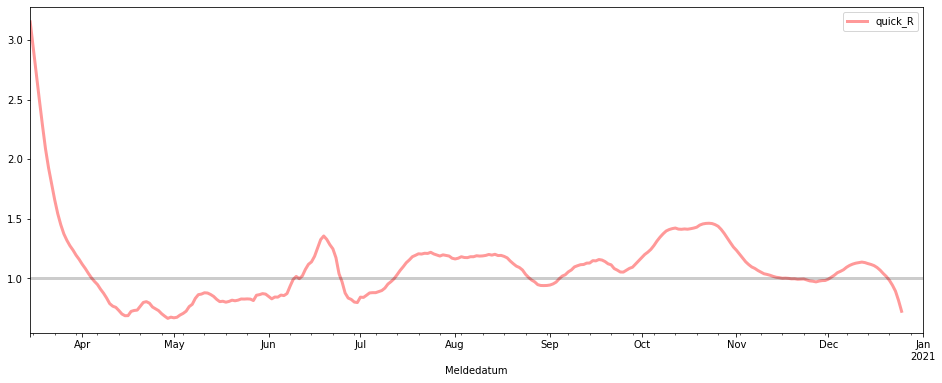

In [7]:
(
    covid.groupby('Meldedatum')[['AnzahlFall']].sum()
    .pipe(weekly_sum_all_wd)
    .pipe(flowing_r_value)
    .rolling(7).mean()
    .loc["2020-03-15":,:].plot(y='quick_R',figsize=(16,6),lw=3,alpha=0.4,c='r')
)
plt.gca().axhline(y=1,lw=3,c='k',alpha=0.2)